In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Dict, Tuple, Optional

import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt

CSV_PATH = Path("sorted_data.csv")

In [2]:
def load_dataset(csv_path: Path = CSV_PATH) -> pd.DataFrame:
    df = pd.read_csv(csv_path)

    if "AudioPath" not in df.columns:
        raise ValueError("CSV must contain an 'AudioPath' column.")
    df["AudioPath"] = (
        df["AudioPath"]
        .astype(str)
        .str.replace("\\", "/", regex=False)
        .apply(lambda p: Path(p) if Path(p).is_absolute() else Path(".") / p)
    )

    if "Gender" in df.columns:
        df["Gender"] = df["Gender"].str.lower()
    if "Native" in df.columns:
        df["Native"] = df["Native"].map({True: "native", False: "non-native"}).fillna("unknown")
    if "Age" in df.columns:
        df["Age"] = df["Age"].astype(str).str.strip()

    return df


def resolve_audio_path(raw_path: Path) -> Optional[Path]:
    if raw_path.exists():
        return raw_path
    candidate = Path("audio_input") / raw_path.name
    if candidate.exists():
        return candidate
    matches = list(Path("audio_input").rglob(raw_path.name))
    if matches:
        return matches[0]

    return None


In [3]:
def attach_durations(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, int]]:
    durations = []
    missing = 0
    failed = 0

    for path in df["AudioPath"]:
        resolved = resolve_audio_path(Path(path))
        if resolved is None:
            durations.append(None)
            missing += 1
            continue

        try:
            info = sf.info(str(resolved))
            durations.append(info.frames / info.samplerate)
        except Exception:
            durations.append(None)
            failed += 1

    df = df.copy()
    df["DurationSec"] = durations
    stats = {
        "available_durations": len(df) - missing - failed,
        "missing_audio": missing,
        "failed_audio": failed,
    }
    return df, stats


def print_distribution(title: str, series: pd.Series, total: int) -> None:
    print(f"\n{title}")
    counts = series.value_counts(dropna=False)
    for key, count in counts.items():
        label = "unknown" if pd.isna(key) or str(key).strip() in {"", "nan"} else str(key)
        pct = (count / total) * 100 if total else 0.0
        print(f"  {label:>10}: {count:4d} ({pct:5.2f}%)")

In [4]:
def summarize(df: pd.DataFrame) -> None:
    total_utts = len(df)
    print(f"Total utterances: {total_utts}")

    if "Split" in df.columns:
        print("Utterances per split:")
        print(df["Split"].value_counts())

    if "Speaker" in df.columns:
        print(f"Unique speakers: {df['Speaker'].nunique()}")


def summarize_durations(df: pd.DataFrame, duration_stats: Dict[str, int]) -> None:
    print("\nDurasi (detik):")
    avail = duration_stats["available_durations"]
    print(f"  Durasi terbaca: {avail} / {len(df)}")
    print(f"  Audio hilang  : {duration_stats['missing_audio']}")
    print(f"  Gagal dibaca  : {duration_stats['failed_audio']}")

    valid = df["DurationSec"].dropna()
    if not valid.empty:
        print(f"  Rata-rata     : {valid.mean():.2f}")
        print(f"  Median        : {valid.median():.2f}")
        print(f"  Min / Max     : {valid.min():.2f} / {valid.max():.2f}")


def summarize_demographics(df: pd.DataFrame) -> None:
    if "Gender" in df.columns:
        print_distribution("Distribusi gender:", df["Gender"], len(df))
    else:
        print("\nDistribusi gender: kolom 'Gender' tidak ditemukan.")

    if "Age" in df.columns:
        print_distribution("Distribusi age:", df["Age"], len(df))
    else:
        print("\nDistribusi age: kolom 'Age' tidak ditemukan.")

    if "Native" in df.columns:
        print_distribution("Distribusi native/non-native:", df["Native"], len(df))
    else:
        print("\nDistribusi native/non-native: kolom 'Native' tidak ditemukan.")


In [5]:
def words_per_utterance(df: pd.DataFrame) -> pd.Series:
    transcripts = df.get("Transcript", pd.Series([], dtype=str)).fillna("").astype(str)
    return transcripts.str.split().str.len()


def plot_distributions(df: pd.DataFrame) -> None:
    words = words_per_utterance(df)
    df = df.copy()
    df["Words"] = words

    native_mask = df["Native"] == "native"
    non_native_mask = df["Native"] == "non-native"
    plt.figure(figsize=(6, 4))
    bins = range(0, int(df["Words"].max()) + 2)
    plt.hist(
        [df.loc[native_mask, "Words"], df.loc[non_native_mask, "Words"]],
        bins=bins,
        stacked=True,
        color=["#2a9d8f", "#e76f51"],
        label=["Native", "Non-native"],
        edgecolor="black",
        alpha=0.8,
    )
    plt.title("Histogram kata per ujaran (stacked)")
    plt.xlabel("Jumlah kata")
    plt.ylabel("Jumlah ujaran")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 4))
    native_counts = df["Native"].value_counts(dropna=False)
    plt.bar(
        native_counts.index.astype(str),
        native_counts.values,
        color=["#264653", "#e76f51", "#b3b3b3"][: len(native_counts)],
    )
    for idx, (label, count) in enumerate(native_counts.items()):
        plt.text(idx, count + 5, str(count), ha="center", va="bottom", fontsize=9)
    plt.title("Distribusi Native vs Non-native")
    plt.ylabel("Jumlah")
    plt.tight_layout()
    plt.show()

    if "Gender" in df.columns:
        plt.figure(figsize=(5, 4))
        gender_counts = df["Gender"].value_counts(dropna=False)
        plt.bar(
            gender_counts.index.astype(str),
            gender_counts.values,
            color=["#457b9d", "#f4a261", "#b3b3b3"][: len(gender_counts)],
        )
        for idx, (label, count) in enumerate(gender_counts.items()):
            plt.text(idx, count + 5, str(count), ha="center", va="bottom", fontsize=9)
        plt.title("Distribusi Gender")
        plt.ylabel("Jumlah")
        plt.tight_layout()
        plt.show()
    else:
        print("\nKolom Gender tidak ditemukan; plot gender tidak ditampilkan.")

Total utterances: 2090
Utterances per split:
Split
train    1470
test      410
val       210
Name: count, dtype: int64
Unique speakers: 70

Durasi (detik):
  Durasi terbaca: 2090 / 2090
  Audio hilang  : 0
  Gagal dibaca  : 0
  Rata-rata     : 4.21
  Median        : 4.03
  Min / Max     : 1.26 / 16.15

Distribusi gender:
        male: 1590 (76.08%)
      female:  500 (23.92%)

Distribusi age: kolom 'Age' tidak ditemukan.

Distribusi native/non-native:
  non-native: 1670 (79.90%)
      native:  420 (20.10%)


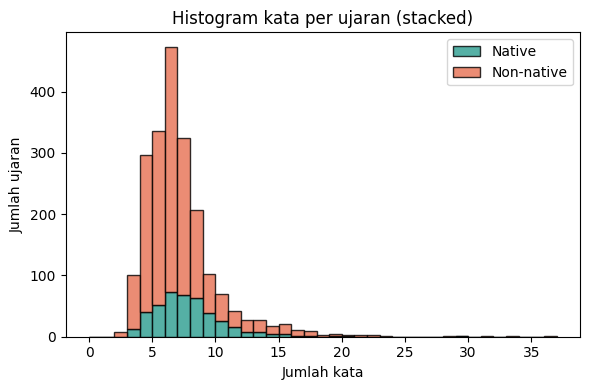

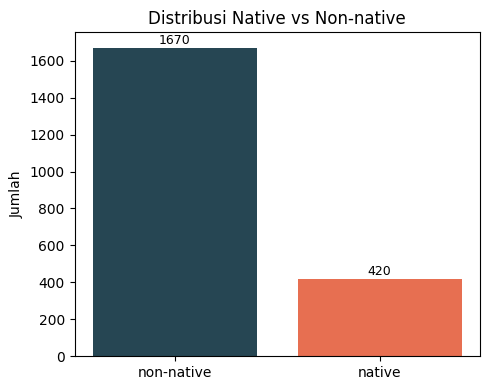

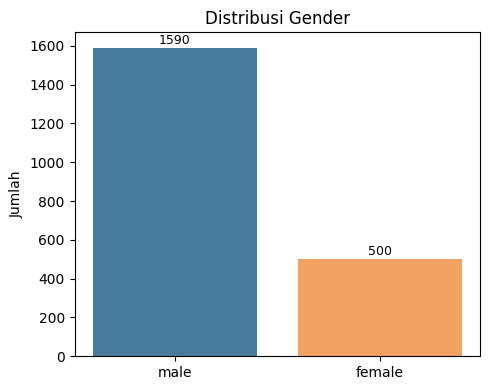

In [6]:
df = load_dataset()
summarize(df)
df, dur_stats = attach_durations(df)
summarize_durations(df, dur_stats)
summarize_demographics(df)
plot_distributions(df)